<a href="https://colab.research.google.com/github/cfong32/netflix-prize/blob/main/step3_torch_sgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# download preprocessed dataset
!wget -qO movie_id2idx.json https://uoguelphca-my.sharepoint.com/:u:/g/personal/chungyan_uoguelph_ca/EQYi9IZtpyBJm328_hkGJDMB7QSgu0glk4L7Zk2ACgq7JQ?download=1
!wget -qO movie_titles.csv https://uoguelphca-my.sharepoint.com/:x:/g/personal/chungyan_uoguelph_ca/EZqcFnpIS7lLmkYaL0bP3BoBjYUezuxR7DLZvqtauHoafA?download=1
!wget -qO ratings_M250.csv https://uoguelphca-my.sharepoint.com/:x:/g/personal/chungyan_uoguelph_ca/EWSo_S3jR_RJuquZFr2Thp8BkPA54pfhZ4Y-YsOx4nRrVg?download=1
# !wget -qO ratings_M18000.csv https://uoguelphca-my.sharepoint.com/:x:/g/personal/chungyan_uoguelph_ca/Ee327xnlX-tMtxTqmlanh4wBh3aDQAtFemy4CaJ_PraDTQ?download=1

In [2]:
# # uncomment to prepare to save model to your google drive
# from google.colab import drive
# drive.mount('/gdrive')

Mounted at /gdrive


# I. Training

In [3]:
import json
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
from sklearn.cluster import KMeans
pd.set_option('display.min_rows', 4)

# check GPU
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print('device:', device)

device: cuda


In [4]:
# read dataset into dataframe

df = (pd.read_csv('ratings_M250.csv')
      .assign(target=lambda x: x.rating/6)
)
N = df.user.nunique()
M = df.movie.nunique()

print('num_user:', N, 'num_movie:', M)
display(df)

num_user: 20068 num_movie: 250


,user,movie,rating,target
0,0,0,3,0.500000
1,1,0,4,0.666667
...,...,...,...,...
286761,19858,249,4,0.666667
286762,20043,249,3,0.500000


In [5]:
# split data into train and test sets

max_test_split = 0.2
max_test_num = 100_000

test  = df.sample(frac=min(max_test_num/len(df), max_test_split))
train = df[~df.index.isin(test.index)]

display(train)
display(test)

,user,movie,rating,target
2,2,0,3,0.500000
3,3,0,3,0.500000
...,...,...,...,...
286761,19858,249,4,0.666667
286762,20043,249,3,0.500000


,user,movie,rating,target
52642,7280,46,4,0.666667
117661,11916,117,3,0.500000
...,...,...,...,...
157693,19171,155,1,0.166667
272790,11838,239,4,0.666667


In [6]:
# build the matrix-multiplication-based model

class MatrixMultiplicationModel(nn.Module):
    def __init__(self, num_user, num_movie, emb_dim):
        super().__init__()
        self.U = nn.Embedding(num_user, emb_dim)    # matrix U, user embeddings, sized N-by-D
        self.V = nn.Embedding(num_movie, emb_dim)   # matrix V, movie embeddings, sized M-by-D
        
    def forward(self, um_idxs):
        u_idx, m_idx = um_idxs[:,0].int(), um_idxs[:,1].int()
        U = self.U(u_idx)                           # retrieve user embeddings by user indexes
        V = self.V(m_idx)                           # retrieve movie embeddings by movie indexes
        dot_products = (U*V).sum(dim=1)             # predicted ratings are their dot products
        # output = torch.sigmoid(dot_products)      # map to [0,1]
        output = dot_products
        return output

In [7]:
# set hyperparameters
D = 2               # embedding dimension
lr = 1e-3           # learning rate
batch_size = 1024
max_epoch = 100_000
patience = 10       # early stop if not improving in this num of evaluations

# convert data to torch datasets and dataloaders
train_um_idx = torch.IntTensor  (train[['user', 'movie']].values).to(device)
train_y      = torch.FloatTensor(train.target.values).to(device)
train_size   = len(train_um_idx)
train_ds     = TensorDataset(train_um_idx, train_y)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)

test_um_idx  = torch.IntTensor  (test[['user', 'movie']].values).to(device)
test_y       = torch.FloatTensor(test.target.values).to(device)

# initialize model and ...
model = MatrixMultiplicationModel(num_user =N,
                                  num_movie=M,
                                  emb_dim  =D).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# train
recs = []
min_test_loss = None
i_batch = 0
not_improving_count = 0

for epoch in range(max_epoch):

    # gradient descent
    model.train()
    for batch_um_idx, batch_y in train_loader:
        optimizer.zero_grad()
        train_y_hat = model(batch_um_idx)
        loss = loss_fn(train_y_hat, batch_y)
        loss.backward()
        optimizer.step()

        # evaluate test loss
        if i_batch % 1000 == 0:
            model.eval()
            test_y_hat = model(test_um_idx)
            test_loss = loss_fn(test_y_hat, test_y).item()
            rec = {
                'epoch'     : epoch,
                'batch'     : i_batch,
                'train_loss': loss.item(),
                'test_loss' : test_loss,
                'patience'  : patience - not_improving_count,
            }
            recs.append(rec)
            print(rec)

            # # uncomment to save checkpoint to your google drive
            # torch.save({
            #     'recs': recs,
            #     'model_state_dict': model.state_dict(),
            #     'optimizer_state_dict': optimizer.state_dict(),
            # }, '/gdrive/MyDrive/Shared/checkpoint.pt')

            # check for early stopping
            if min_test_loss is None or test_loss < min_test_loss:
                min_test_loss = test_loss
                not_improving_count = 0
            else:
                not_improving_count += 1
                if not_improving_count >= patience:
                    break
        i_batch += 1

    if not_improving_count >= patience:
        break

{'epoch': 0, 'batch': 0, 'train_loss': 2.1392383575439453, 'test_loss': 2.313999891281128, 'patience': 10}
{'epoch': 4, 'batch': 1000, 'train_loss': 0.8328069448471069, 'test_loss': 0.8262041211128235, 'patience': 10}
{'epoch': 8, 'batch': 2000, 'train_loss': 0.4654587507247925, 'test_loss': 0.49694666266441345, 'patience': 10}
{'epoch': 13, 'batch': 3000, 'train_loss': 0.394584983587265, 'test_loss': 0.41075602173805237, 'patience': 10}
{'epoch': 17, 'batch': 4000, 'train_loss': 0.3810148537158966, 'test_loss': 0.3855532109737396, 'patience': 10}
{'epoch': 22, 'batch': 5000, 'train_loss': 0.372686505317688, 'test_loss': 0.37431737780570984, 'patience': 10}
{'epoch': 26, 'batch': 6000, 'train_loss': 0.34547528624534607, 'test_loss': 0.3532726466655731, 'patience': 10}
{'epoch': 31, 'batch': 7000, 'train_loss': 0.2799373269081116, 'test_loss': 0.28727883100509644, 'patience': 10}
{'epoch': 35, 'batch': 8000, 'train_loss': 0.1920492947101593, 'test_loss': 0.20401228964328766, 'patience':

# II. Analysis

In [ ]:
# # uncomment to save checkpoint to your google drive
# torch.save({
#     'recs': recs,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
# }, '/gdrive/MyDrive/Shared/checkpoint_torch_sgd_M250v2_D2.pt')

In [ ]:
# # uncomment to load checkpoint from your google drive
# ckpt = torch.load('/gdrive/MyDrive/Shared/checkpoint_torch_sgd_M250v2_D2.pt')
# recs = ckpt['recs']
# optimizer.load_state_dict(ckpt['optimizer_state_dict'])
# model.load_state_dict(ckpt['model_state_dict'])
# model.eval()

## Training Curves

<Axes: xlabel='batch'>

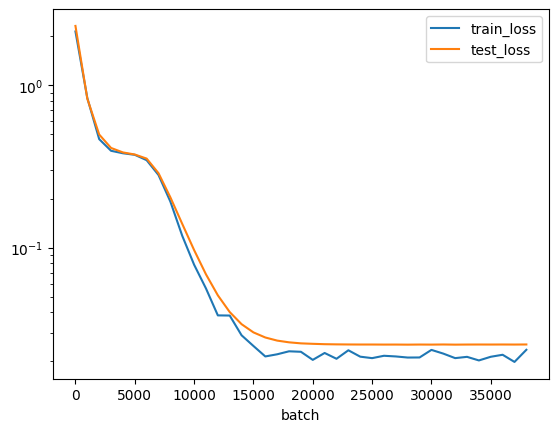

In [ ]:
# training curves
pd.DataFrame(recs).set_index('batch')[['train_loss', 'test_loss']].plot(logy=True)

## Predictions

In [9]:
# prediction results

test_y_hat = model(test_um_idx).cpu().detach().numpy()

df_res = (
    test
    .assign(target_pred    =test_y_hat,
            rating_pred    =lambda x: (x.target_pred*6).clip(1,5),  # clipped between 1 and 5
            rating_residual=lambda x: x.rating - x.rating_pred)
)

df_res.sample(10)

,user,movie,rating,target,target_pred,rating_pred,rating_residual
22995,12909,27,3,0.500000,0.647318,3.883907,-0.883907
69145,1453,69,2,0.333333,0.332683,1.996099,0.003901
252661,13173,214,2,0.333333,0.464401,2.786406,-0.786406
128827,989,137,1,0.166667,0.475995,2.855972,-1.855972
185681,18531,174,4,0.666667,0.579276,3.475658,0.524342
161149,15770,164,5,0.833333,0.725006,4.350036,0.649964
268149,13781,231,2,0.333333,0.431426,2.588556,-0.588556
243797,18580,198,5,0.833333,0.673909,4.043457,0.956543
223829,2661,196,3,0.500000,0.430996,2.585974,0.414026
279286,11786,240,4,0.666667,0.561331,3.367983,0.632017


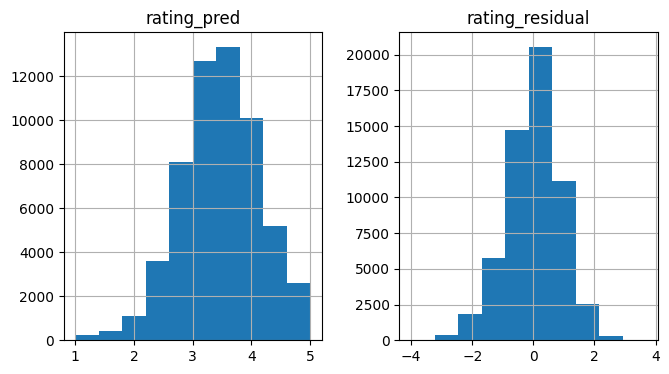

In [10]:
# distribution of residuals
df_res[['rating_pred', 'rating_residual']].hist(figsize=(12,4), layout=(1,3))
plt.show()

In [19]:
print('distribution of rating_residual:')
for i in [1, 2, 3, 4]:
    print(f'within [-{i},+{i}] = '
          f'{(df_res.rating_residual.abs()<=i).sum()/len(df_res):%}')

distribution of rating_residual:
within [-1,+1] = 75.539205%
within [-2,+2] = 97.063798%
within [-3,+3] = 99.813436%
within [-4,+4] = 100.000000%


## Movie Embeddings (the $V$ matrix)

In [ ]:
# resulted V
V = model.V.weight.cpu().detach().numpy()
print('first few rows of,')
print('V:', V[:5])

first few rows of,
V: [[-0.4428131   0.42010766]
 [-0.3896725   0.396521  ]
 [-0.44163156  0.4189314 ]
 [-0.29290658  0.2859428 ]
 [-0.41955966  0.4005767 ]]


In [ ]:
# gether movie information
movie_id2idx = json.load(open('movie_id2idx.json'))
df_movie = (pd.read_csv('movie_titles.csv',
                        encoding="latin",
                        usecols=range(3),
                        names=['movie_id', 'year', 'title'])
            .assign(movie_id=lambda x: x.movie_id.astype(str).map(movie_id2idx),
                    year    =lambda x: x.year.astype(str).str.replace('.0', '', regex=False))
            .head(len(V))
            )
df_movie['V_0'] = V[:,0]
df_movie['V_1'] = V[:,1]

# cluster movies based on the learned embeddings in V
n_clusters = 12
kmeans = KMeans(n_clusters=n_clusters).fit(V)
df_movie['kmeans_cluster'] = kmeans.labels_

df_movie

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,movie_id,year,title,V_0,V_1,kmeans_cluster
0,0,2003,Dinosaur Planet,-0.442813,0.420108,1
1,1,2004,Isle of Man TT 2004 Review,-0.389672,0.396521,1
...,...,...,...,...,...,...
248,248,1958,The Hunters,-0.391669,0.317444,0
249,249,1966,Cast a Giant Shadow,-0.432507,0.381782,1


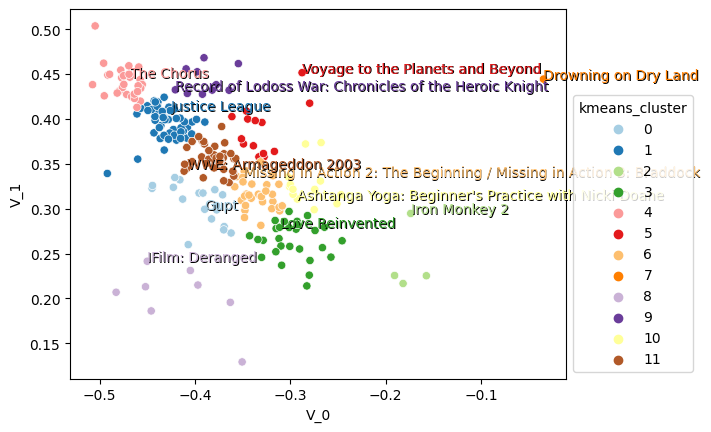

In [ ]:
# plot movie clusters in 2D embedding space

data = (df_movie
        .sort_values('kmeans_cluster')
        .assign(kmeans_cluster=lambda x: x.kmeans_cluster.astype(str))
        )


palette = sns.color_palette("Paired")
sns.scatterplot(
    data=data,
    x='V_0',
    y='V_1',
    hue='kmeans_cluster',
    palette=palette,
)

for _, x in df_movie.groupby('kmeans_cluster').sample(n=1, random_state=3).iterrows():
    d = 0.001
    plt.text(x.V_0+d, x.V_1-d, x.title, color='black')
    plt.text(x.V_0,   x.V_1,   x.title, color=palette[x.kmeans_cluster])

plt.legend(loc='lower left', bbox_to_anchor=(1,0), title='kmeans_cluster')
plt.show()

In [ ]:
# sample one movie from each cluster
# locate their nearest neighbours

nnrecs = []
for _, x in df_movie.groupby('kmeans_cluster').sample(n=1, random_state=3).iterrows():
    dfx = (
        df_movie
        .assign(dist=lambda y: ((y.V_0-x.V_0)**2 + (y.V_1-x.V_1)**2)**0.5)
        .sort_values('dist')
        .head(4)
    )
    nnrecs.append({
        'cluster'        : x.kmeans_cluster,
        'seed movie'     : f'{dfx.iloc[0].title}({dfx.iloc[0].year})',
        'closest_movie_1': f'{dfx.iloc[1].title}({dfx.iloc[1].year})',
        'closest_movie_2': f'{dfx.iloc[2].title}({dfx.iloc[2].year})',
    })

pd.set_option('display.max_colwidth', None)
df_nn = pd.DataFrame(nnrecs)
df_nn

,cluster,seed movie,closest_movie_1,closest_movie_2
0,0,Gupt(1997),Denise Austin: Ultimate Fat Burner(2001),Classic Albums: Meat Loaf: Bat Out of Hell(1999)
1,1,Justice League(2001),The Great Race(1965),The Devil's Brigade(1968)
2,2,Iron Monkey 2(1996),Sleepover Nightmare(2005),Horror Vision(2000)
3,3,Love Reinvented(2000),Dona Herlinda and Her Son(1985),Arachnid(2002)
4,4,The Chorus(2004),Star Trek: Deep Space Nine: Season 5(1996),Invader Zim(2004)
5,5,Voyage to the Planets and Beyond(2005),Beyonce: Live at Wembley(2003),ECW: Cyberslam '99(2002)
6,6,Missing in Action 2: The Beginning / Missing in Action 3: Braddock(1985),Jade(1995),Cherry 2000(1988)
7,7,Drowning on Dry Land(1999),Iron Monkey 2(1996),Read-Along: Beauty and the Beast(2002)
8,8,IFilm: Deranged(2005),Winston Churchill: The Wilderness Years(1983),Fighter(2001)
9,9,Record of Lodoss War: Chronicles of the Heroic Knight(1998),WWE: Royal Rumble 2005(2005),Richard III(1995)


## User Embeddings (the $U$ matrix)

In [ ]:
# resulted U
U = model.U.weight.cpu().detach().numpy()
print('first few rows of,')
print('U:', U[:5])

first few rows of,
U: [[-0.37264574  0.95308447]
 [-1.3176689  -0.0067542 ]
 [-1.8186882  -0.2944722 ]
 [-0.21463159  1.1322075 ]
 [-0.20713605  1.6937875 ]]


In [ ]:
# sample a few users and find their best movies (which was rated the highest)

n_sample = 3
df_user = (
    pd.DataFrame({'U_0': U[:,0], 'U_1': U[:,1]})
    .reset_index()
    .rename(columns={'index': 'user_id'})
    .sample(n_sample, random_state=4)
)

df_user = df_user.join(
    df[df.user.isin(df_user.index)]
    .sort_values('rating')
    .groupby('user')
    .tail(1)
    .set_index('user')
    .movie
    .rename('best_movie_id')
    .to_frame()
)
df_user['best_movie_title'] = df_user.best_movie_id.map(df_movie.set_index('movie_id').title)
df_user['best_movie_year'] = df_user.best_movie_id.map(df_movie.set_index('movie_id').year)

df_user

,user_id,U_0,U_1,best_movie_id,best_movie_title,best_movie_year
14609,14609,-2.079875,-0.822031,115,Bear Cub,2004
8134,8134,-1.275474,0.144893,239,Woman of the Year,1942
4060,4060,0.353005,1.535963,56,Richard III,1995


In [ ]:
# recommend movie to them based on the learned embeddings U and V

recommend_id = (df_user[['U_0', 'U_1']].values @ V.T).argmax(axis=1)
pd.concat([
    df_user.reset_index(drop=True),
    (df_movie.set_index('movie_id')[['title', 'year']]
     .loc[recommend_id]
     .reset_index()
     .rename(columns={'movie_id': 'recommend_id',
                      'title'   : 'recommend_title',
                      'year'    : 'recommend_year'})
     .reset_index(drop=True)
    )
], axis=1)

,user_id,U_0,U_1,best_movie_id,best_movie_title,best_movie_year,recommend_id,recommend_title,recommend_year
0,14609,-2.079875,-0.822031,115,Bear Cub,2004,175,The History Channel Presents: Troy: Unearthing the Legend,2004
1,8134,-1.275474,0.144893,239,Woman of the Year,1942,12,Lord of the Rings: The Return of the King: Extended Edition: Bonus Material,2003
2,4060,0.353005,1.535963,56,Richard III,1995,129,Drowning on Dry Land,1999
